In [1]:
"""
author: Vetivert? 💐 
created: 13/03/2025 @ 12:46:33
"""

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold # type: ignore
from sklearn.preprocessing import StandardScaler, label_binarize # type: ignore
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.prefix_path import *

In [ ]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True) #indexes of 2019 data 
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.27, '2': 39.8, '3': 3.93}


In [204]:
df.loc[:, :'Oliguria'].isnull().sum() #check missing values

Diagnosis                       0
Gende                           0
DHF infection His.              4
additional_diseases             0
Fever                           2
Bleeding                        2
Fatigue                         2
Day of illness                  3
Level of temp                 184
Duration fever                192
Headache                        2
Body ache                       2
Rash                            2
hematoma                        0
Mucosa membrane bleeding        0
Pleural effusion                2
Ascites                         2
Pericardial effusion            2
Vomiting                        3
Abdominal pain or tendness      3
Liver enlargement               3
Oliguria                        5
dtype: int64

## STRATEGY 1, 20% test_set = 0.2 * range(line 0, line 221) + 0.2 * range(line 222, line 407)

x1_train shape:  (330, 19) y1_train shape:  (330,)
x1_test shape:  (77, 19) y1_test shape:  (77,)
percentage of classes:  {'1': 58.44, '2': 38.96, '3': 2.6}
Accuracy: 0.74
percentage of predictions:  {'1': 67.53, '2': 32.47}


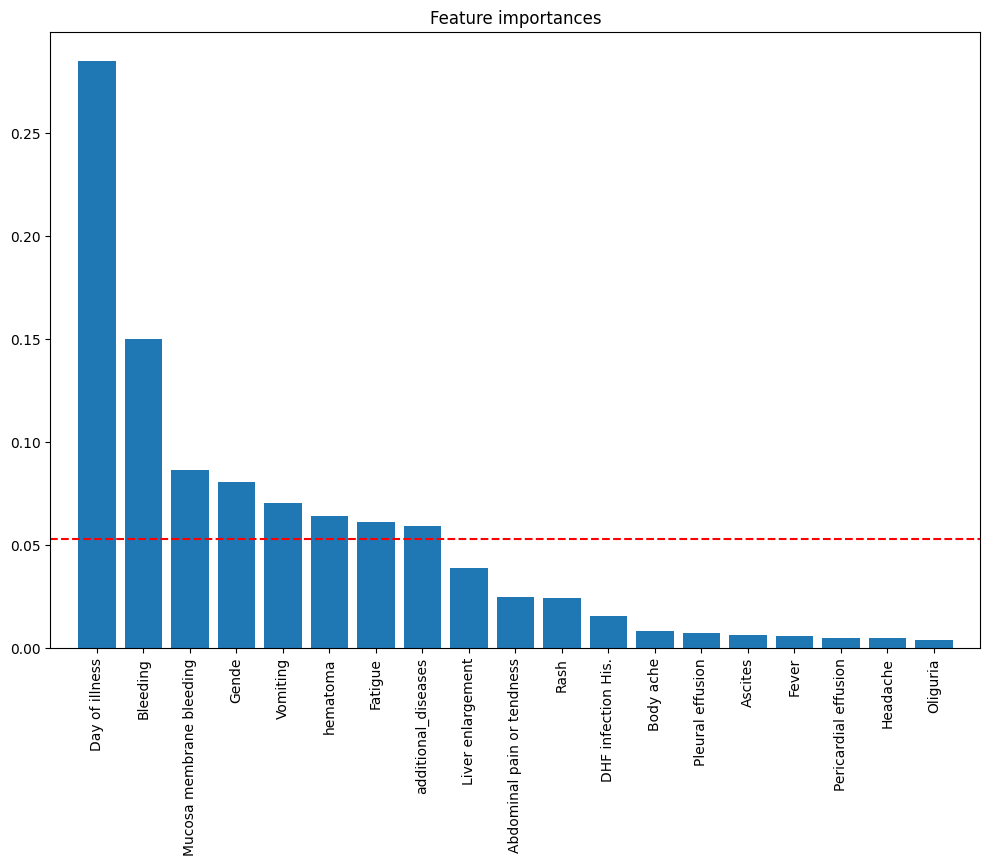

In [ ]:
# strategy 1, 20% test_set = 0.2 * range(line 0, line 221) + 0.2 * range(line 222, line 407)
df_train = df.drop(MISSING_2017, axis=1).copy().loc[:, :'Oliguria']

# np.random.seed(2)
x_0_1_2017 = np.random.randint(221, size=(int(0.2 * 221)))
x_0_1_2019 = np.random.randint(203, size=(int(0.2 * 203)))
x_0_1_2019 = x_0_1_2019 + 203 # add 203 to the random numbers to get the correct index in 2019 part

testset_index = x_0_1_2017.tolist() + x_0_1_2019.tolist()
testset_index = list(dict.fromkeys(testset_index)) # remove duplicates
df_test = df_train.iloc[testset_index, :].copy()
df_test

df_train.drop(testset_index, inplace=True)

x1_train = df_train.drop(columns=['Diagnosis'], axis=1)
y1_train = df_train['Diagnosis']

x1_test = df_test.drop(columns=['Diagnosis'], axis=1)
y1_test = df_test['Diagnosis']
print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_1.fit(x1_train, y1_train)

y1_pred = rf_1.predict(x1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y1_test, y1_pred))

uniques, counts = np.unique(y1_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y1_pred), 2))))

# Plotting feature importances
importances = rf_1.feature_importances_
indices = np.argsort(importances)[::-1]
features = x1_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x1_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x1_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

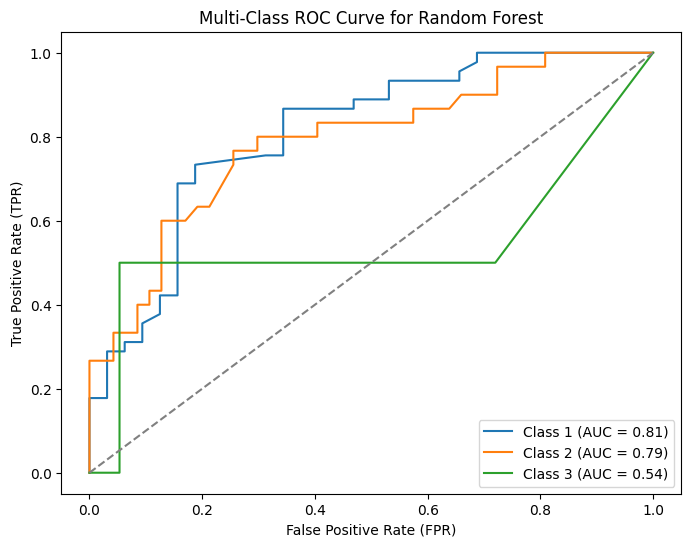

In [109]:
# ROC curve

# Get Predicted Probabilities for Each Class
y_probs = rf_1.predict_proba(x1_test)  # Shape: (num_samples, num_classes)
y_bin = label_binarize(df['Diagnosis'].to_numpy(), classes=np.unique(df['Diagnosis'].to_numpy()))  # Binarize the labels
y1_test_bin = label_binarize(y1_test, classes=np.unique(y1_test))  # Binarize the test labels
# Compute ROC Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8,6))
for i in range(y_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y1_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the Random Classifier Line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Baseline

# Final Plot Customization
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()

#### strat_1: optimization

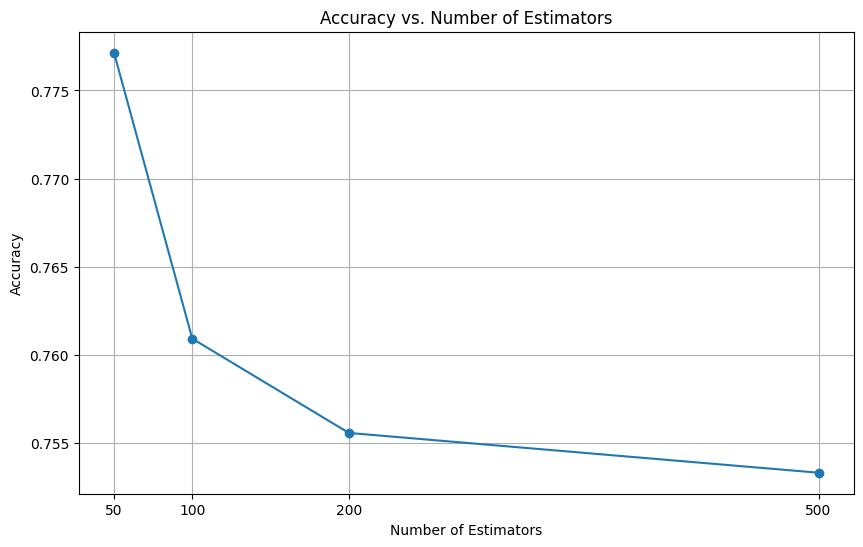

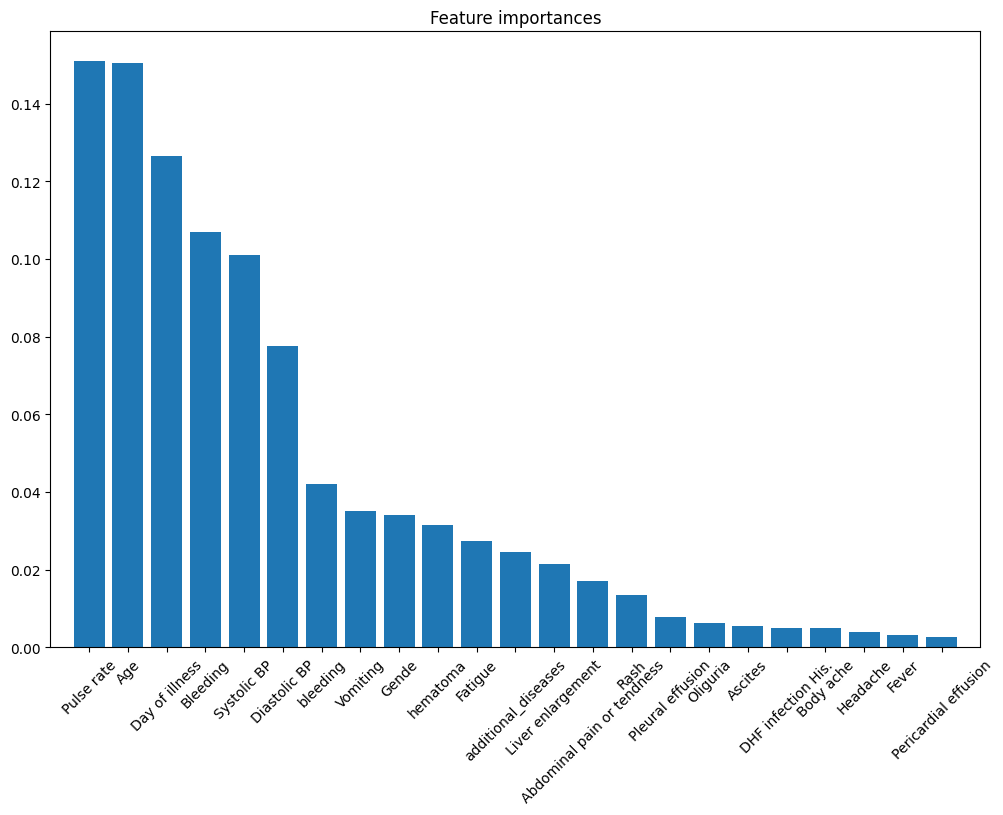

In [ ]:
# finding optimal parameters
n_estimators = [50, 100, 200, 500]
n_splits = [5, 10, 20]
accuracy_scores = []

for n in n_estimators:
    for s in n_splits:
        skf = StratifiedKFold(n_splits=s, shuffle=True, random_state=42)
        
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(x1_train, y1_train)
        # y_pred = rf.predict(x1_test)
        scores = cross_val_score(rf, x1_test, y1_test, cv=skf)  # k-fold cross-validation
        # print(n, scores)
        accuracy_scores.append(np.mean(scores))

accuracy_scores = np.array(accuracy_scores)   
# print(len(accuracy_scores))    
accuracy_scores = np.reshape(accuracy_scores, (3,4))
# print(accuracy_scores)
accuracy_scores = accuracy_scores.mean(axis=0)
# print(accuracy_scores)
# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, accuracy_scores, marker='o')
plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.xticks(n_estimators)
plt.grid()
plt.show()




## STRATEGY 2, 20% test_set = 0.2 * whole dataset => acc 52% ~ 73%

x2_train shape:  (325, 19) y2_train shape:  (325,)
x2_test shape:  (82, 19) y2_test shape:  (82,)
Accuracy: 0.60
percentage of classes:  {'1': 53.66, '2': 42.68, '3': 3.66}
percentage of predictions:  {'1': 63.41, '2': 35.37, '3': 1.22}


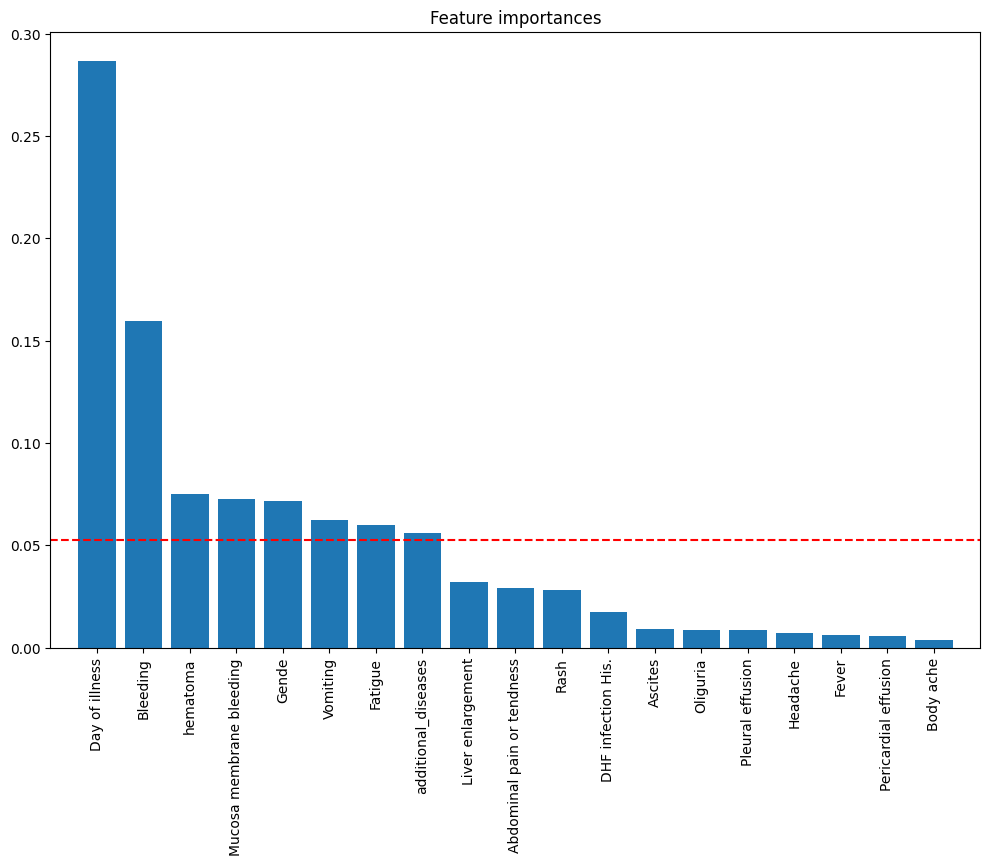

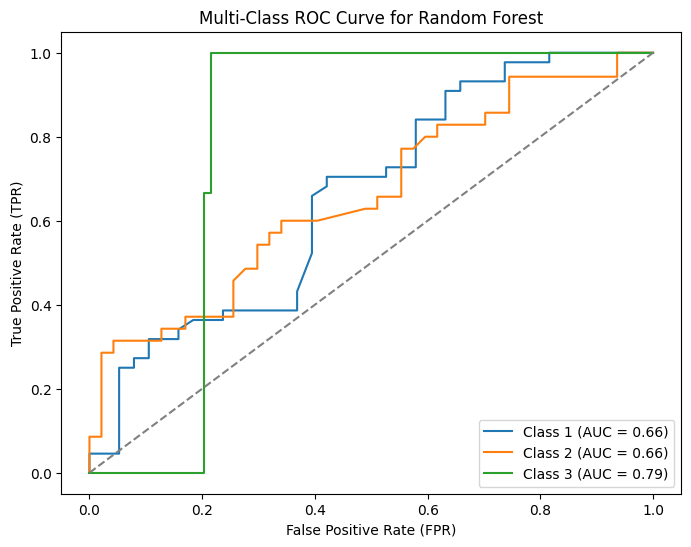

In [ ]:
# strategy 2, 20% test_set = 0.2 * whole dataset => acc 52% ~ 73%
df_train = df.drop(MISSING_2017, axis=1).copy().loc[:, :'Oliguria']
X = df_train.drop(columns=['Diagnosis'], axis=1)
Y = df_train['Diagnosis']

x2_train, x2_test, y2_train, y2_test = train_test_split(X, Y, test_size=0.2, random_state=None)
print('x2_train shape: ', x2_train.shape, 'y2_train shape: ',  y2_train.shape)
print('x2_test shape: ', x2_test.shape, 'y2_test shape: ',  y2_test.shape)

rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2.fit(x2_train, y2_train)

y2_pred = rf_2.predict(x2_test)
accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y2_test, y2_pred))

uniques, counts = np.unique(y2_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y2_test), 2))))
uniques, counts = np.unique(y2_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y2_pred), 2))))

importances = rf_2.feature_importances_
indices = np.argsort(importances)[::-1]
features = x2_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x2_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x2_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x2_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

### ROC curve

# Get Predicted Probabilities for Each Class
y2_probs = rf_2.predict_proba(x2_test)  # Shape: (num_samples, num_classes)
y2_bin = label_binarize(df['Diagnosis'].to_numpy(), classes=np.unique(df['Diagnosis'].to_numpy()))  # Binarize the labels
y2_test_bin = label_binarize(y2_test, classes=np.unique(y2_test))  # Binarize the test labels
# Compute ROC Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8,6))
for i in range(y2_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y2_test_bin[:, i], y2_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the Random Classifier Line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Baseline

# Final Plot Customization
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()

#### strategy 2: optimization

## STRATEGY 3: keep missing data 2017  = 'Level of temp' and 'Duration fever', train on 2019 then test on 2017

x3_train shape:  (185, 21) y3_train shape:  (185,)
x3_test shape:  (222, 21) y3_test shape:  (222,)
percentage of classes:  {'1': 58.44155844155844, '2': 38.96103896103896, '3': 2.5974025974025974}
Accuracy: 0.59


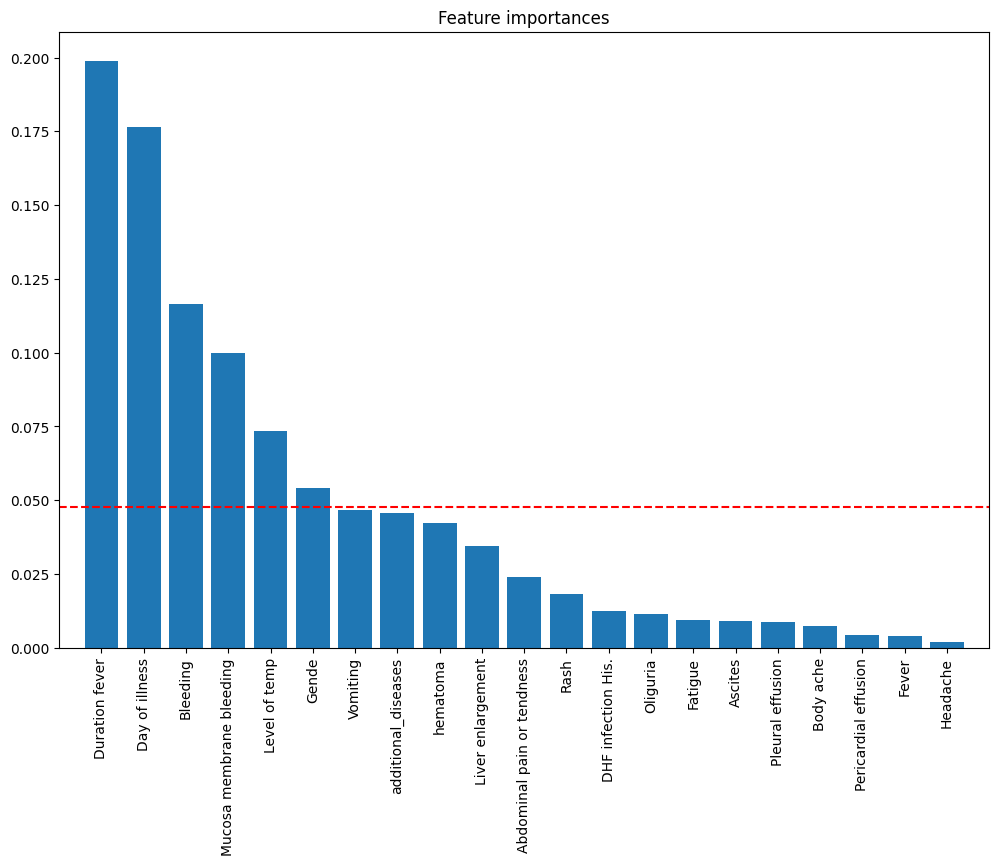

In [ ]:
# strategy 3: keep missing data 2017  = 'Level of temp' and 'Duration fever', train on 2019 then test on 2017
df_train = df.loc[222:, :'Oliguria'].copy()
df_test = df.loc[:221, :'Oliguria'].copy()

for i in range(len(MISSING_2017)):
    df_test[MISSING_2017[i]] = pd.to_numeric(df_test[MISSING_2017[i]], errors='coerce')
    df_test[MISSING_2017[i]].fillna(value = df_test[MISSING_2017[i]].mean(), inplace=True) # fillna with mean value of 2017
# df_test
x3_train = df_train.drop(columns=['Diagnosis'], axis=1)
y3_train = df_train['Diagnosis']
x3_test = df_test.drop(columns=['Diagnosis'], axis=1)
y3_test = df_test['Diagnosis']

# x3_train, x3_test, y3_train, y3_test = train_test_split(X, Y, test_size=0.2, random_state=42 )
print('x3_train shape: ', x3_train.shape, 'y3_train shape: ',  y3_train.shape)
print('x3_test shape: ', x3_test.shape, 'y3_test shape: ',  y3_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, counts * 100 / len(y1_test))))

rf_3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_3.fit(x3_train, y3_train)

y3_pred = rf_3.predict(x3_test)
accuracy = accuracy_score(y3_test, y3_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y2_test, y2_pred))

importances = rf_3.feature_importances_
indices = np.argsort(importances)[::-1]
features = x3_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x3_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x3_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x3_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

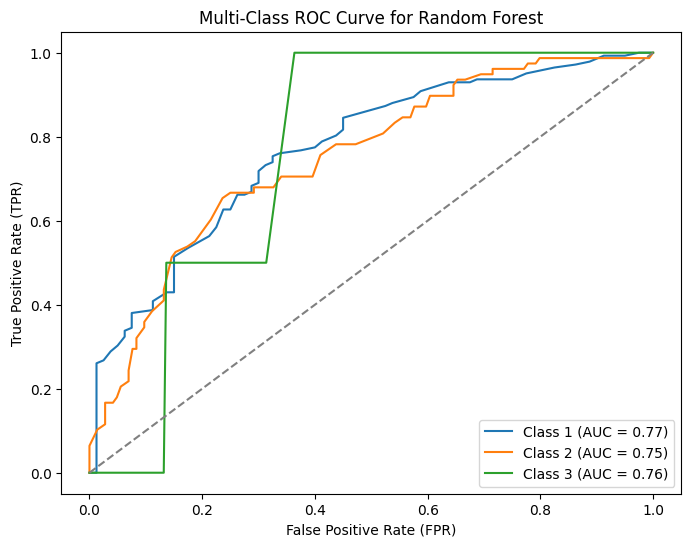

In [85]:
# ROC curve

# Get Predicted Probabilities for Each Class
y3_probs = rf_3.predict_proba(x3_test)  # Shape: (num_samples, num_classes)
y_bin = label_binarize(df['Diagnosis'].to_numpy(), classes=np.unique(df['Diagnosis'].to_numpy()))  # Binarize the labels
y3_test_bin = label_binarize(y3_test, classes=np.unique(y3_test))  # Binarize the test labels
# Compute ROC Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8,6))
for i in range(y_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y3_test_bin[:, i], y3_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the Random Classifier Line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Baseline

# Final Plot Customization
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()

## STRATEGY 4: using only 2019 data


x4_train shape:  (148, 21) y4_train shape:  (148,)
x4_test shape:  (37, 21) y4_test shape:  (37,)
percentage of classes:  {'1': 48.65, '2': 43.24, '3': 8.11}
Accuracy: 0.65
percentage of predictions:  {'1': 43.24, '2': 54.05, '3': 2.7}


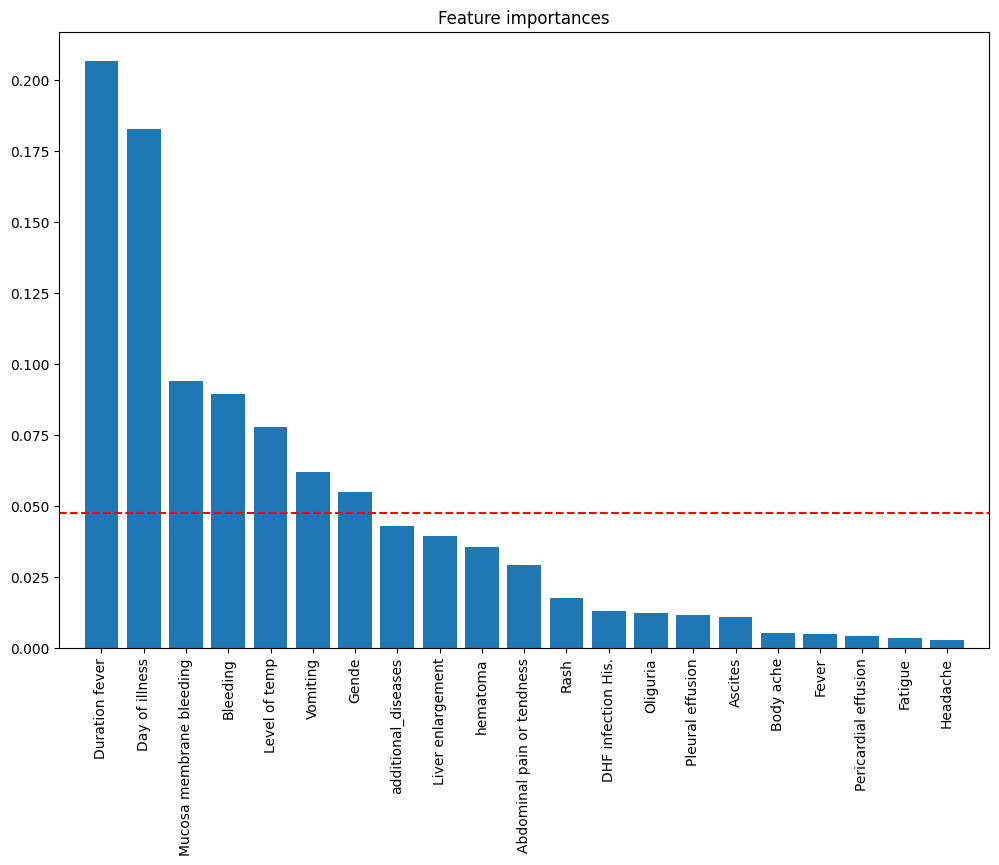

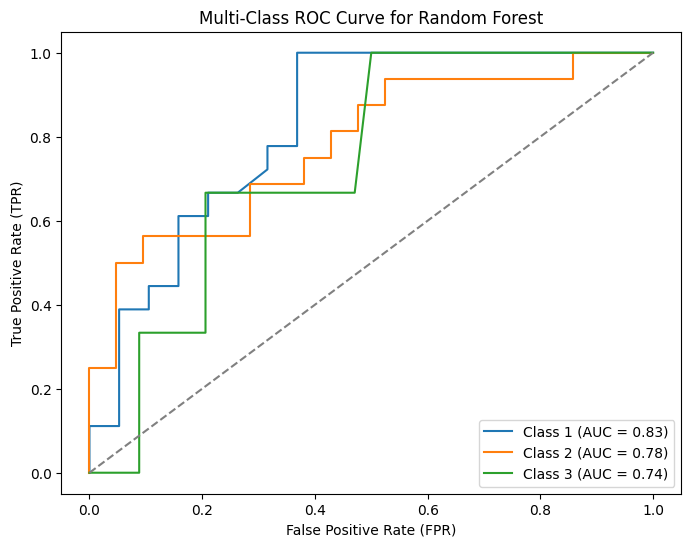

In [ ]:
# strategy 4: using only 2019 data
df_strat4 = df.loc[222:, :'Oliguria'].copy()

X_4 = df_strat4.drop(columns=['Diagnosis'], axis=1)
Y_4 = df_strat4['Diagnosis']

x4_train, x4_test, y4_train, y4_test = train_test_split(X_4, Y_4, test_size=0.2, random_state=None )
print('x4_train shape: ', x4_train.shape, 'y4_train shape: ',  y4_train.shape)
print('x4_test shape: ', x4_test.shape, 'y4_test shape: ',  y4_test.shape)
uniques, counts = np.unique(y4_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y4_test), 2))))

rf_4 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_4.fit(x4_train, y4_train)

y4_pred = rf_4.predict(x4_test)
accuracy = accuracy_score(y4_test, y4_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y2_test, y2_pred))
uniques, counts = np.unique(y4_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y4_pred), 2))))

importances = rf_4.feature_importances_
indices = np.argsort(importances)[::-1]
features = x4_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x4_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x4_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x4_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

### ROC curve

# Get Predicted Probabilities for Each Class
y4_probs = rf_4.predict_proba(x4_test)  # Shape: (num_samples, num_classes)
y4_bin = label_binarize(df['Diagnosis'].to_numpy(), classes=np.unique(df['Diagnosis'].to_numpy()))  # Binarize the labels
y4_test_bin = label_binarize(y4_test, classes=np.unique(y4_test))  # Binarize the test labels
# Compute ROC Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8,6))
for i in range(y4_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y4_test_bin[:, i], y4_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the Random Classifier Line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Baseline

# Final Plot Customization
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()

## STRATEGY 5: balancing the dataset

X_train_resampled shape:  (415, 19) y_train_resampled shape:  (415,)
x5_test shape:  (102, 19) y_test_resampled shape:  (102,)
percentage of classes:  {'1': 55.88, '2': 40.2, '3': 3.92}
Accuracy: 0.66
percentage of predictions:  {'1': 54.9, '2': 43.14, '3': 1.96}


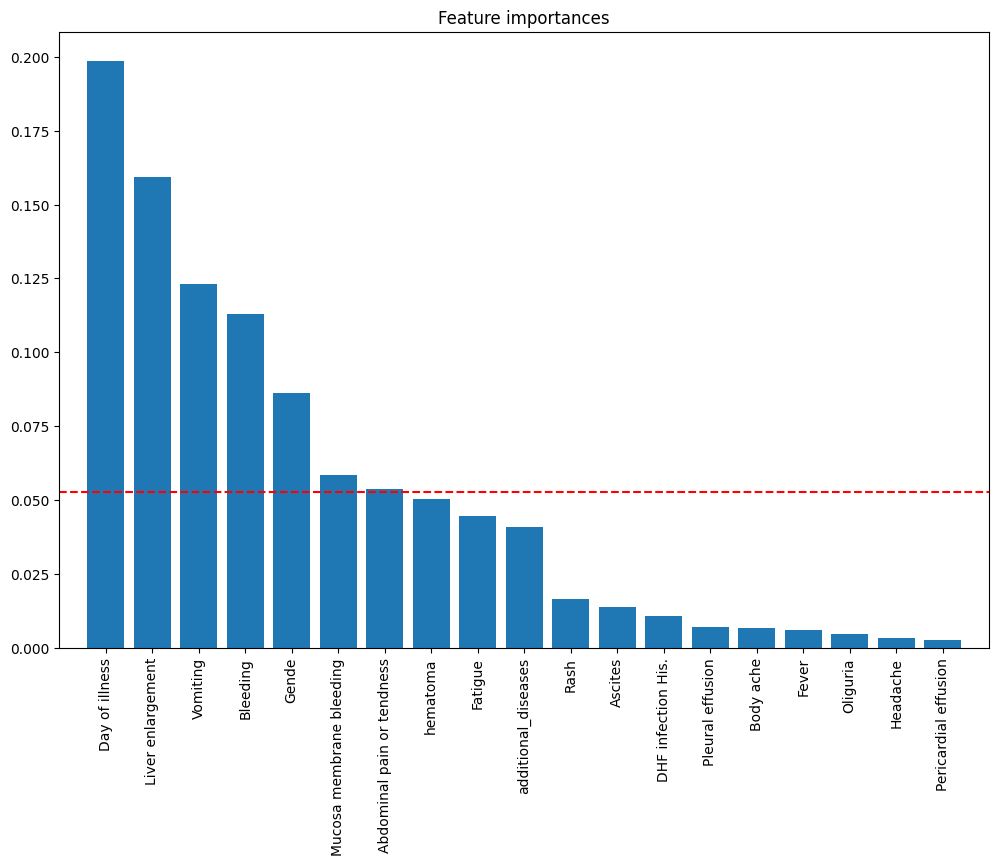

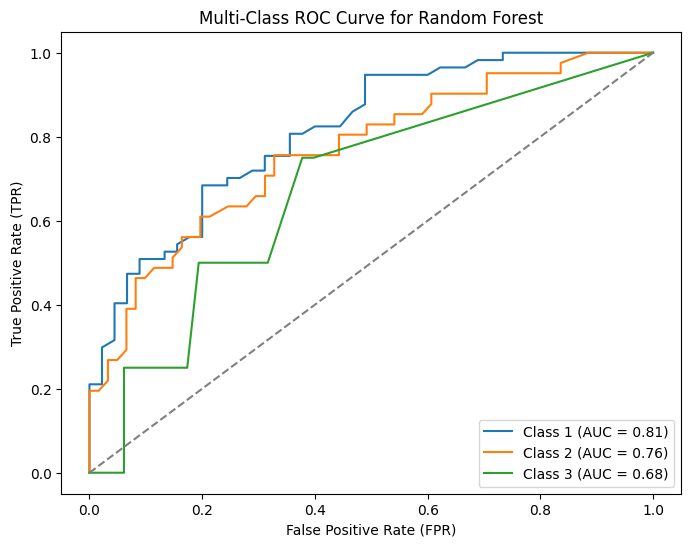

In [ ]:
from imblearn.over_sampling import SMOTE # type: ignore
df_strat_5 = df.drop(MISSING_2017, axis=1).copy().loc[:, :'Oliguria']
# df_strat_5 = pd.to_numeric(df_strat_5, errors='coerce')
df_strat_5 = df_strat_5.fillna(0)
# df_strat_5.isnull().sum() #check missing values

X_5 = df_strat_5.drop(columns=['Diagnosis'], axis=1)
Y_5 = df_strat_5['Diagnosis']

x5_train, x5_test, y5_train, y5_test = train_test_split(X_5, Y_5, test_size=0.25, random_state=None )
# uniques, counts = np.unique(y5_train, return_counts=True)
# print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y5_train), 2))))

# Apply SMOTE to only the minority class (Class 2)
smote = SMOTE(sampling_strategy={'3': int(0.4 * len(y5_train))}, random_state=42)  
X_train_resampled, y_train_resampled = smote.fit_resample(x5_train, y5_train)
# smote_test = SMOTE(sampling_strategy={'3': int(0.4 * len(y5_test))}, random_state=42)  
# X_test_resampled, y_test_resampled = smote_test.fit_resample(x5_test, y5_test)

print('X_train_resampled shape: ', X_train_resampled.shape, 'y_train_resampled shape: ',  y_train_resampled.shape)
print('x5_test shape: ', x5_test.shape, 'y5_test shape: ',  y5_test.shape)
uniques, counts = np.unique(y5_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y5_test), 2))))

rf_5 = RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42)
rf_5.fit(X_train_resampled, y_train_resampled)

y5_pred = rf_5.predict(x5_test)
accuracy = accuracy_score(y5_test, y5_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y2_test, y2_pred))
uniques, counts = np.unique(y5_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y5_pred), 2))))

importances = rf_5.feature_importances_
indices = np.argsort(importances)[::-1]
features = x5_test.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x5_test.shape[1]), importances[indices], align="center")
plt.xticks(range(x5_test.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x5_test.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

### ROC curve

# Get Predicted Probabilities for Each Class
y5_probs = rf_5.predict_proba(x5_test)  # Shape: (num_samples, num_classes)
y5_bin = label_binarize(df['Diagnosis'].to_numpy(), classes=np.unique(df['Diagnosis'].to_numpy()))  # Binarize the labels
y5_test_bin = label_binarize(y5_test, classes=np.unique(y5_test))  # Binarize the test labels
# Compute ROC Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8,6))
for i in range(y5_bin.shape[1]):  # Loop over each class
    fpr[i], tpr[i], _ = roc_curve(y5_test_bin[:, i], y5_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the Random Classifier Line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Baseline

# Final Plot Customization
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.show()


## LSTM for time-series data

In [ ]:
#LSTM for time-series data

## CORR MATRIX

/tmp/ipykernel_9498/1763557890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.loc[:, :'Oliguria'].corr()


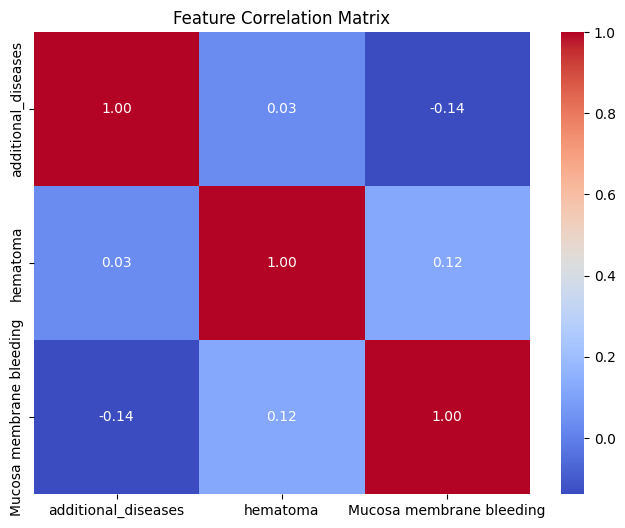

In [87]:
corr_matrix = df.loc[:, :'Oliguria'].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## MR.TEST

In [ ]:
#MR. TEST
# df_train.iloc[0]
# df_test 
from sklearn.datasets import make_classification



{'1': 53.84615384615385, '2': 41.02564102564103, '3': 5.128205128205129}
